In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
file_path = "synthetic_keystroke_emotion_dataset.csv"
df = pd.read_csv(file_path)

# 1. Drop user_id (not useful for prediction)
df = df.drop(columns=["user_id"])

# 2. Encode Emotion labels (target variable)
label_encoder = LabelEncoder()
df["Emotion"] = label_encoder.fit_transform(df["Emotion"])

# 3. Separate features and target
X = df.drop(columns=["Emotion"])
y = df["Emotion"]

# 4. Scale features (keystroke timings vary in scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("y_train distribution:\n", pd.Series(y_train).value_counts())


X_train shape: (2000, 7)
y_train distribution:
 Emotion
3    400
1    400
2    400
4    400
0    400
Name: count, dtype: int64


In [2]:
import numpy as np

# Show first 5 rows after preprocessing
print("Scaled features (first 5 rows):\n", X_train[:5])
print("\nTarget values (first 5):", y_train[:5])
print("\nEmotion labels mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Scaled features (first 5 rows):
 [[-0.85124157 -2.03549962 -0.22193547 -0.28863526  1.00105914  1.11632669
   0.85847754]
 [ 0.11053904  0.90053363 -1.11314722 -1.52867774 -1.10977241 -1.23382157
  -0.53607383]
 [-1.04536982  1.50049948  0.20109071  0.35788262 -0.99741829 -1.3278275
   0.71349942]
 [-0.42270951  0.39231167 -0.58883024 -0.30453324 -1.01748624 -1.39049812
  -0.384192  ]
 [-1.31441062  1.75719061  0.1911891   0.03992301  0.898739   -0.01174447
   1.30721931]]

Target values (first 5): 824     3
2312    1
2488    3
1052    2
1018    4
Name: Emotion, dtype: int64

Emotion labels mapping: {'Angry': np.int64(0), 'Calm': np.int64(1), 'Happy': np.int64(2), 'Neutral': np.int64(3), 'Sad': np.int64(4)}


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 2. Support Vector Machine
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# 3. Neural Network (MLP)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# 📊 Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))

print("\nRandom Forest Report:\n", classification_report(y_test, y_pred_rf))
print("\nSVM Report:\n", classification_report(y_test, y_pred_svm))
print("\nMLP Report:\n", classification_report(y_test, y_pred_mlp))


Random Forest Accuracy: 0.606
SVM Accuracy: 0.65
MLP Accuracy: 0.592

Random Forest Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87       100
           1       0.48      0.51      0.49       100
           2       0.67      0.70      0.69       100
           3       0.37      0.30      0.33       100
           4       0.62      0.62      0.62       100

    accuracy                           0.61       500
   macro avg       0.59      0.61      0.60       500
weighted avg       0.59      0.61      0.60       500


SVM Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       100
           1       0.52      0.60      0.56       100
           2       0.71      0.72      0.71       100
           3       0.43      0.32      0.37       100
           4       0.69      0.70      0.69       100

    accuracy                           0.65       500
   macro avg       0.64 

c:\Users\sande\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


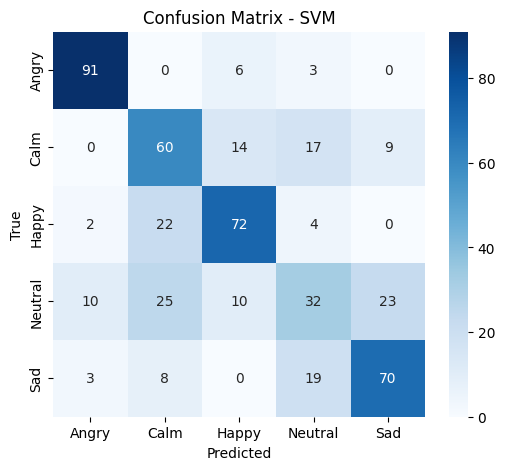

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix for the best model (SVM here)
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM")
plt.show()


In [5]:
# Feature engineering
df["SpeedComplexityRatio"] = df["TypingSpeed"] / (df["SentenceComplexity"] + 1e-5)
df["ErrorSpeedRatio"] = df["ErrorRate"] / (df["TypingSpeed"] + 1e-5)
df["DwellFlightRatio"] = df["DwellTime"] / (df["FlightTime"] + 1e-5)
df["KeysPerSecond"] = df["NumKeys"] / (df["TotalTime"] + 1e-5)


In [6]:
from sklearn.decomposition import PCA

# Reduce to top 5 components
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)


In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": [0.01, 0.1, 1],
    "kernel": ["rbf"]
}

grid = GridSearchCV(SVC(), param_grid, cv=3, scoring="accuracy", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

best_svm = grid.best_estimator_
y_pred_best = best_svm.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-val accuracy: 0.6354945650297975
Test Accuracy: 0.65

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       100
           1       0.52      0.60      0.56       100
           2       0.71      0.73      0.72       100
           3       0.41      0.31      0.35       100
           4       0.69      0.70      0.70       100

    accuracy                           0.65       500
   macro avg       0.64      0.65      0.64       500
weighted avg       0.64      0.65      0.64       500



In [8]:
import joblib
joblib.dump(best_svm, "emotion_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [10]:
import numpy as np
import joblib

# Load artifacts
loaded_model = joblib.load("emotion_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")
loaded_encoder = joblib.load("label_encoder.pkl")

def predict_emotion(features: dict, top_k: int = 3):
    """
    Predict emotion from keystroke features.
    Returns top_k predictions with confidence scores.
    """
    x = np.array([[features["TypingSpeed"], features["DwellTime"], features["FlightTime"],
                   features["ErrorRate"], features["TotalTime"], features["NumKeys"], features["SentenceComplexity"],
                   features["TypingSpeed"] / (features["SentenceComplexity"] + 1e-5),
                   features["ErrorRate"] / (features["TypingSpeed"] + 1e-5),
                   features["DwellTime"] / (features["FlightTime"] + 1e-5),
                   features["NumKeys"] / (features["TotalTime"] + 1e-5)]])
    
    x_scaled = loaded_scaler.transform(x)
    probs = loaded_model.predict_proba(x_scaled)[0]
    top_indices = np.argsort(probs)[::-1][:top_k]
    top_predictions = [
        (loaded_encoder.inverse_transform([i])[0], round(float(probs[i]), 3)) 
        for i in top_indices
    ]
    return {"top_predictions": top_predictions}

In [11]:
def predict_emotion(features: dict, top_k: int = 3):
    """
    Predict emotion from keystroke features (7 original features only).
    """
    x = np.array([[features["TypingSpeed"], features["DwellTime"], features["FlightTime"],
                   features["ErrorRate"], features["TotalTime"], features["NumKeys"], features["SentenceComplexity"]]])

    # Scale features
    x_scaled = loaded_scaler.transform(x)

    # Predict probabilities
    probs = loaded_model.predict_proba(x_scaled)[0]

    # Get top predictions
    top_indices = np.argsort(probs)[::-1][:top_k]
    top_predictions = [
        (loaded_encoder.inverse_transform([i])[0], round(float(probs[i]), 3)) 
        for i in top_indices
    ]

    return {"top_predictions": top_predictions}


In [13]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train, y_train)


SVC(probability=True, random_state=42)

In [14]:
joblib.dump(svm, "emotion_model.pkl")


['emotion_model.pkl']

In [16]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train, y_train)


SVC(probability=True, random_state=42)

In [17]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("SVM Report:\n", classification_report(y_test, y_pred))


SVM Accuracy: 0.65
SVM Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       100
           1       0.52      0.60      0.56       100
           2       0.71      0.72      0.71       100
           3       0.43      0.32      0.37       100
           4       0.69      0.70      0.69       100

    accuracy                           0.65       500
   macro avg       0.64      0.65      0.64       500
weighted avg       0.64      0.65      0.64       500



In [18]:
import joblib

joblib.dump(svm, "emotion_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [23]:
x = np.array([[5.2, 120, 130, 0.02, 14.2, 78, 0.45]])
x_scaled = scaler.transform(x)

probs = svm.predict_proba(x_scaled)[0]
print("Probabilities:", probs)


Probabilities: [0.00719576 0.4556592  0.112227   0.33093555 0.09398249]


c:\Users\sande\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [25]:
# Get probabilities
x = np.array([[5.2, 120, 130, 0.02, 14.2, 78, 0.45]])
x_scaled = scaler.transform(x)
probs = svm.predict_proba(x_scaled)[0]

# Map to emotion labels
emotion_names = label_encoder.inverse_transform(np.arange(len(probs)))
results = dict(zip(emotion_names, probs))

print("Probabilities by Emotion:")
for emotion, p in results.items():
    print(f"{emotion}: {p:.3f}")


Probabilities by Emotion:
Angry: 0.007
Calm: 0.456
Happy: 0.112
Neutral: 0.331
Sad: 0.094


c:\Users\sande\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
